<a href="https://colab.research.google.com/github/choderalab/pinot/blob/master/scripts/playground_uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! rm -rf /content/pinot/
! git clone https://github.com/choderalab/pinot.git -b samplers
import sys
sys.path.append('/content/pinot/')
import torch
! pip install dgl
import dgl

Cloning into 'pinot'...
remote: Enumerating objects: 358, done.
remote: Counting objects: 100% (358/358), done.
remote: Compressing objects: 100% (260/260), done.
remote: Total 1970 (delta 230), reused 177 (delta 96), pack-reused 1612
Receiving objects: 100% (1970/1970), 160.66 MiB | 32.02 MiB/s, done.
Resolving deltas: 100% (946/946), done.


Using backend: pytorch


In [0]:
import pinot
import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt

In [0]:
# define the target
f = lambda x: torch.sin(x)

x_tr = torch.tensor(np.concatenate(
    [
        np.linspace(-3 * math.pi, -math.pi, 50),
        np.linspace(math.pi, 3 * math.pi, 50)
    ]),
    dtype=torch.float32)[:, None]

x_te = torch.tensor(np.concatenate(
    [
        np.linspace(-7 * math.pi, -3 * math.pi, 100),
        np.linspace(-math.pi, math.pi, 50),
        np.linspace(3 * math.pi, 7 * math.pi, 100)
    ]),
    dtype=torch.float32)[:, None]

x = torch.tensor(np.linspace(-7 * math.pi, 7 * math.pi, 375),
                 dtype=torch.float32)[:, None]


y_tr = f(x_tr)
y_te = f(x_te)
y = f(x)


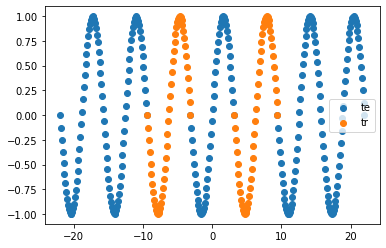

In [4]:
plt.scatter(x_te, y_te, label='te')
plt.scatter(x_tr, y_tr, label='tr')
plt.legend()

In [0]:
net_representation = torch.nn.Sequential(
        torch.nn.Linear(1, 32),
        torch.nn.Tanh(),
        torch.nn.Linear(32, 32),
        torch.nn.Tanh())

net = pinot.Net(net_representation, noise_model='normal-heteroschedastic')

In [0]:
opt = pinot.BBB(
    torch.optim.Adam(net.parameters(), 1e-3), 
    0.01, 
    theta_prior=torch.distributions.normal.Normal(0, 1))

# opt = torch.optim.Adam(net.parameters(), 1e-3)

# opt = pinot.AdLaLa(
#     params=[
#             {'params': net.representation.parameters()},
#             {'params': net._output_regression.parameters()},

#     ],
#     h=1e-3)

for _ in range(4000):
    def l():
        opt.zero_grad()
        loss = net.loss(x_tr, y_tr).sum()
        loss.backward()
        return loss
        
    opt.step(l)

In [0]:
def plot(net):
    from pinot.inference import utils
    plt.figure(figsize=(10, 6))
    y_hat_distribution = pinot.inference.utils.condition_mixture(net, x, sampler=opt, n_samples=1000)

    nll = y_hat_distribution.log_prob(y) / float(y.shape[0])

    plt.plot(x, y_hat_distribution.mean, c='k', linewidth=5)

    low, high = pinot.inference.utils.confidence_interval(y_hat_distribution, 0.95, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.1)
    
    low, high = pinot.inference.utils.confidence_interval(y_hat_distribution, 0.75, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.2)

    low, high = pinot.inference.utils.confidence_interval(y_hat_distribution, 0.50, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.3)

    low, high = pinot.inference.utils.confidence_interval(y_hat_distribution, 0.25, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.4)

    plt.scatter(x_te, y_te, label='te')
    plt.scatter(x_tr, y_tr, label='tr')
    plt.legend()
    plt.ylim(-2, 2)
    plt.title('NLL=%s' % nll.detach().numpy().round(3))



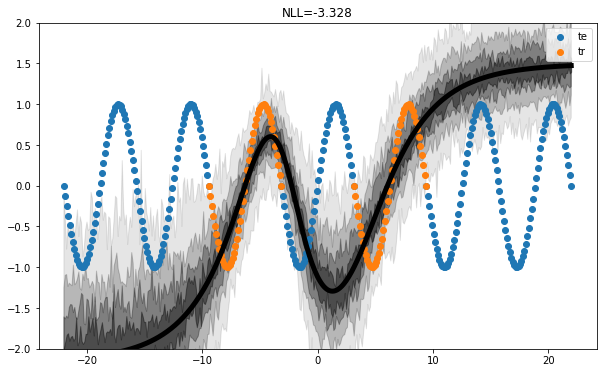

In [17]:
plot(net)